<a href="https://colab.research.google.com/github/villifCoder559/VGGFaceFeatures_PCA/blob/main/VGGFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install faiss-cpu --no-cache

In [2]:
%%capture
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install tensorflow keras_applications
!pip install layer_utils

In [3]:
%%capture
!pip install keras==2.12

In [4]:
import numpy as np
import pandas as pd
import cv2
import keras
from keras_vggface.vggface import VGGFace
from sklearn.datasets import fetch_lfw_people
from skimage.transform import resize
import faiss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

<h1>Balancing Dataset

In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=55, resize=2.4,color=True)

In [6]:
np.random.seed(42)
data=lfw_people.images
target=lfw_people.target
index_list,nr_elements_per_class=np.unique(target,return_counts=True)
min_elements=min(nr_elements_per_class)
balanced_data=[]
balanced_target=[]
for s_class in index_list:
  print(s_class)
  list_indices = np.argwhere(target == s_class).reshape(-1)
  choices = np.random.choice(list_indices, min_elements, replace = False)
  balanced_target.append(np.full(min_elements,s_class))
  balanced_data.append(data[choices])
balanced_data=np.array(balanced_data)
balanced_target=np.array(balanced_target)
balanced_data=balanced_data.reshape(balanced_data.shape[0]*balanced_data.shape[1],balanced_data.shape[2],balanced_data.shape[3],balanced_data.shape[4])
balanced_target=balanced_target.reshape(-1)

0
1
2
3
4
5
6
7
8


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_target, test_size=0.2, random_state=2)

<h1>Image normalization and standardization

In [8]:
image_samples_train=np.copy(X_train)
image_samples_train=np.array([cv2.resize(img,(224,224)) for img in image_samples_train])
image_samples_train[:,:,:,0]=(image_samples_train[:,:,:,0]-np.mean(X_train[:,:,:,0]))/(np.std(X_train[:,:,:,0]))
image_samples_train[:,:,:,1]=(image_samples_train[:,:,:,1]-np.mean(X_train[:,:,:,1]))/(np.std(X_train[:,:,:,1]))
image_samples_train[:,:,:,2]=(image_samples_train[:,:,:,2]-np.mean(X_train[:,:,:,2]))/(np.std(X_train[:,:,:,2]))

In [9]:
image_samples_test=np.copy(X_test)
image_samples_test=np.array([cv2.resize(img,(224,224)) for img in image_samples_test])
image_samples_test[:,:,:,0]=(image_samples_test[:,:,:,0]-np.mean(X_train[:,:,:,0]))/(np.std(X_train[:,:,:,0]))
image_samples_test[:,:,:,1]=(image_samples_test[:,:,:,1]-np.mean(X_train[:,:,:,1]))/(np.std(X_train[:,:,:,1]))
image_samples_test[:,:,:,2]=(image_samples_test[:,:,:,2]-np.mean(X_train[:,:,:,2]))/(np.std(X_train[:,:,:,2]))

<h1>Extract features

In [ ]:
vggface = VGGFace(model='vgg16',include_top=False,input_shape=(image_samples_train.shape[1],image_samples_train.shape[2],image_samples_train.shape[3]))
result_train=vggface.predict(image_samples_train)
result_test=vggface.predict(image_samples_test)
original_result_train=np.copy(result_train)
original_result_test=np.copy(result_test)

<h1>Save/load features from drive

In [130]:
from google.colab import drive
import os
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/'
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'), original_result_train)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'), original_result_test)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_train.npy'), original_result_train)
# np.save(os.path.join(drive_path, 'VGGFace_features_faces_test.npy'), original_result_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'original_result_train' is not defined

In [10]:
from google.colab import drive
import os
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/'
result_train_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_train.npy'),allow_pickle=True)
result_test_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_norm_std_test.npy'),allow_pickle=True)
# result_train_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_train.npy'),allow_pickle=True)
# result_test_vgg=np.load(os.path.join(drive_path, 'VGGFace_features_faces_test.npy'),allow_pickle=True)

Mounted at /content/drive


In [11]:
#create reduction (if n_components is negative it means to remove the first n_components instead of lasts)
def create_test_reduction(n_components,result_train,type_index='FlatL2',fixed_components=30):
  if type_index not in ['FlatL2', 'FlatIP']:
        raise ValueError("Type must be 'FlatL2' or 'FlatIP'")
  features_reducted=result_train.reshape(result_train.shape[0],-1)
  if n_components > 0:
    tmp_PCA=PCA(n_components=n_components)
    features_reducted=np.ascontiguousarray(tmp_PCA.fit_transform(features_reducted))
  else:
    tmp_PCA=PCA(n_components=fixed_components).fit(features_reducted)
    features_reducted=custom_reduction(tmp_PCA,result_train,n_components)
  faiss.normalize_L2(features_reducted)
  if type_index=='FlatIP':
    return tmp_PCA,features_reducted,faiss.IndexFlatIP(features_reducted.shape[1])
  else:
    return tmp_PCA,features_reducted,faiss.IndexFlatL2(features_reducted.shape[1])

In [12]:
def custom_reduction(pca,result_train,start_index):
  transformed_results = []
  for element in result_train:
    test = element.reshape(1, -1)
    # Apply PCA transformation
    transformed_result = np.dot(test - pca.mean_, pca.components_[(-start_index):].T)
    transformed_results.append(transformed_result)
  return np.array(transformed_results).reshape(result_train.shape[0],pca.components_.shape[0]+start_index)

<h1>Create Tests

In [13]:
list_n_components=[0,20,100] #0 -> No PCA, -K -> Without first K eigenvectors, +K -> Use K components
# list_n_components=range(0,-6,-1)
index_type='FlatIP' # FlatIP or FlatL2
fixed_components=396 #20, 50, 396 w/o normalization
print('Fixed_componnets=',fixed_components)
pca_objs=[]
features_objs=[]
index_faiss_objs=[]
for n_components in list_n_components:
  if n_components>0:
    pca,features,index=create_test_reduction(n_components,result_train_vgg,index_type)
    pca_objs.append(pca)
    features_objs.append(features)
    index_faiss_objs.append(index)
  else:
    if(n_components<0):
      pca,features,index=create_test_reduction(n_components,result_train_vgg,index_type,fixed_components)
      pca_objs.append(pca)
      features_objs.append(features)
      index_faiss_objs.append(index)
    else: # dummy PCA
      pca_objs.append(PCA())
      res_train_norm=np.copy(result_train_vgg.reshape(result_train_vgg.shape[0],-1))
      faiss.normalize_L2(res_train_norm)
      features_objs.append(res_train_norm)
      if index_type=='FlatIP':
        index_faiss_objs.append(faiss.IndexFlatIP(res_train_norm.shape[1]))
      else:
        index_faiss_objs.append(faiss.IndexFlatL2(res_train_norm.shape[1]))
#add vectors to index
count=0
for index in index_faiss_objs:
  print(features_objs[count].shape)
  index.add(features_objs[count])
  count=count+1

Fixed_componnets= 396
(396, 25088)
(396, 20)
(396, 100)


In [14]:
def compute_precision_recall(ground_truth,target,index_faiss,top_k,reduced_vector):
  TP=-1
  reduced_vector=np.ascontiguousarray(reduced_vector.reshape(1, -1))
  # print(reduced_vector.shape)
  _,retrived_elements=index.search(reduced_vector, X_train.shape[0])
  retrived_targets_id=ground_truth[retrived_elements]==target
  indices = np.where(retrived_targets_id.reshape(-1))[0]
  if(top_k>len(indices)):
    # print('Face nr.',target,'max elements:',len(indices)-1,'(NOT',str(top_k)+')')
    top_k=len(indices)
  stop=indices[top_k-1]+1
  TP=top_k
  total_samples=np.sum(ground_truth==target)
  FP=stop-TP
  FN=total_samples-TP
  precision=0
  if TP+FP!=0:
    precision=TP/(TP+FP)
  recall=TP/((TP+FN))
  return precision,recall

<h1>Compute Precision-recall

In [15]:
import time
list_top_elements=[5,10,20,100]
i=0
j=0
k=0
precision_results=[]
recall_results=[]
name_results=[]
list_precision_results=[]
list_recall_results=[]
test_vectors=result_test_vgg.reshape(result_test_vgg.shape[0],-1)
for top_k in list_top_elements:
  for index in index_faiss_objs:
    # start=time.time()
    for vector in test_vectors:
      if list_n_components[i] > 0:
        reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_.T
      else:
        if list_n_components[i] < 0:
          reduced_vector=(vector.reshape(1,-1)-pca_objs[i].mean_)@pca_objs[i].components_[-list_n_components[i]:].T
        else:
          reduced_vector=vector
      reduced_vector=reduced_vector/np.linalg.norm(reduced_vector)
      precision,recall=compute_precision_recall(y_train,y_test[j],index,top_k,reduced_vector)
      name_results.append(y_test[j])
      precision_results.append(precision)
      recall_results.append(recall)
      j=j+1
    j=0
    i=i+1
  i=0
    # tmp=time.time()-start
recall_results=np.array(recall_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
precision_results=np.array(precision_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])
name_results=np.array(name_results).reshape(len(list_top_elements),len(index_faiss_objs),test_vectors.shape[0])

In [16]:
def create_DataFrame(id_labels,selected_name_result,selected_precision_result,normalization_factors,index_faiss_n_components,list_n_components,index_selected_top_k_retrival):
  str_top_k=str(list_top_elements[index_selected_top_k_retrival])
  text=''
  index_type=''
  precision_vector=np.bincount(selected_name_result,weights=selected_precision_result)/normalization_factors
  recall_vector=np.bincount(selected_name_result,weights=selected_recall_result)/normalization_factors
  # F1_vector=2*(precision_vector*recall_vector)/(precision_vector+recall_vector)
  if index_faiss_objs[index_faiss_n_components].__class__.__name__ == 'IndexFlatIP':
    index_type='(IP)'
  else:
    index_type='(L2)'
  if list_n_components[index_faiss_n_components]<0:
    text='/'+str(fixed_components)
  df = pd.DataFrame({
    "Faces":id_labels,
    # ("F"+index_type+"@"+str_top_k+'_'+str(list_n_components[index_faiss_n_components])+text):F1_vector        # F1
    ("P"+index_type+"@"+str_top_k+'_'+str(list_n_components[index_faiss_n_components])+text):precision_vector,  # Precision
    # ("R@"+str_top_k+'_'+str(list_n_components[index_faiss_n_components])):recall_vector,                      # Recall
  })
  return df

In [17]:
df_list=[]
avg_precision=[]
for i in range(precision_results.shape[0]):
  for j in range(precision_results.shape[1]):
    selected_name_result = name_results[i][j]
    selected_recall_result = recall_results[i][j]
    selected_precision_result = precision_results[i][j]
    avg_precision.append(np.mean(selected_precision_result))
    id_labels,normalization_factors = np.unique(y_test,return_counts=True)
    df=create_DataFrame(id_labels,selected_name_result,selected_precision_result,normalization_factors,j,list_n_components,i)
    df_list.append(df)
avg_precision=np.array(avg_precision).reshape(len(list_top_elements),len(list_n_components))

F1 Score all retrived<br>
P(IP)@1000_0    -> F-Score(distance_InnerProduct)@all_elements_noPCAReduction<br>
P(IP)@1000_200  ->F-Score(distance_InnerProduct)@all_elements_PCA_200_Components<br>
P(IP)@1000_-2/25-> F-Score(Distance_InnerProduct)@W/h first 2 componets out of 25

In [18]:
merged_df_list=[]
count=0
for pick_top_k in list_top_elements:
  merged_df=df_list[count]
  for i in range(count+1,count+int(len(df_list)/len(list_top_elements))):
    merged_df=pd.merge(merged_df,df_list[i])
  merged_df_list.append(merged_df.drop(columns=['Faces']).style.highlight_min(color = 'red', axis = 1).highlight_max(color = 'green', axis = 1))
  count+=int(len(df_list)/len(list_top_elements))

In [31]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import faiss

class TestRunner:
    def __init__(self, train_data, train_labels, test_data, test_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.list_top_elements = [5, 10, 20, 100]  # Define your list of top K values here
        self.index_faiss_objs = []  # Initialize a list to store Faiss indices
        self.list_n_components = [0, 20, 100]  # Define your list of PCA components here
        self.fixed_components = 396  # Define your fixed number of PCA components here
        self.df_list = []  # Initialize a list to store DataFrames

    def run_tests(self):
        for top_k in self.list_top_elements:
            for n_components in self.list_n_components:
                pca, features, index = self.create_test_reduction(n_components)
                self.index_faiss_objs.append(index)

                precision_results, recall_results, name_results = [], [], []
                for vector, target_label in zip(self.test_data, self.test_labels):
                    reduced_vector = self.reduce_vector(vector, pca, n_components)
                    precision, recall = self.compute_precision_recall(target_label, index, top_k, reduced_vector)
                    precision_results.append(precision)
                    recall_results.append(recall)
                    name_results.append(target_label)

                df = self.create_DataFrame(name_results, precision_results, recall_results, n_components, top_k)
                self.df_list.append(df)

In [149]:
merged_df_list[1]

,P(IP)@10_-1/20,P(IP)@10_-2/20,P(IP)@10_-3/20
0,1.000000,0.976584,0.937190
1,0.640026,0.648816,0.591184
2,0.937322,0.971380,0.971380
3,0.729374,0.778492,0.784222
4,0.859755,0.851852,0.954157
5,0.914855,0.871902,0.867146
6,0.965618,0.915404,0.878050
7,0.990909,1.000000,0.983333
8,0.793497,0.792768,0.806789


In [99]:
merged_df_list[2]

,P(IP)@20_-1/20,P(IP)@20_-2/20,P(IP)@20_-3/20
0,0.995671,0.951980,0.924252
1,0.368724,0.424052,0.426769
2,0.861269,0.912901,0.957095
3,0.677690,0.709503,0.722432
4,0.616620,0.683867,0.743346
5,0.862425,0.850613,0.849875
6,0.712311,0.694344,0.658319
7,0.939588,0.986957,0.935439
8,0.743749,0.752754,0.794904


In [100]:
merged_df_list[3]

,P(IP)@100_-1/20,P(IP)@100_-2/20,P(IP)@100_-3/20
0,0.575600,0.451909,0.288942
1,0.117296,0.121623,0.129018
2,0.344907,0.495838,0.491590
3,0.183016,0.197563,0.216664
4,0.139411,0.163926,0.193407
5,0.257766,0.288908,0.291075
6,0.170303,0.166184,0.172079
7,0.516472,0.347231,0.303382
8,0.263458,0.238671,0.288147


In [19]:
avg_prec_T=avg_precision
table={}
for i in range(avg_prec_T.shape[0]):
  table['P@'+str(list_top_elements[i])]=avg_prec_T[i]
df_avg=pd.DataFrame(table,index=['','','','',''])
df_avg.insert(0,'comp. PCA',list_n_components)
df_avg.style.format(precision=2)

ValueError: Length of values (3) does not match length of index (5)

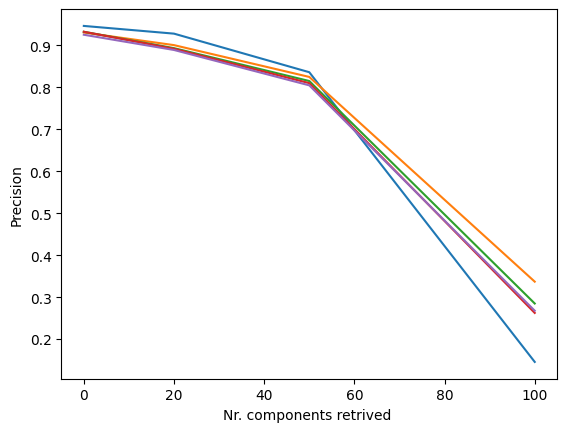

In [ ]:
x_axis=[]
y_axis=[]
for i in range(avg_precision.shape[0]):
  x_axis.append(list_n_components[i])
  y_axis.append(avg_precision[i][:])
plt.plot(x_axis, y_axis)
plt.xlabel('Nr. components retrived ')
plt.ylabel('Precision')
# plt.title('Title of the Plot')
plt.show()

In [20]:
merged_df=df_list[0]
for i in range(1,len(df_list)):
  merged_df=pd.merge(merged_df,df_list[i])
merged_df.drop(columns=['Faces']).style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

,P(IP)@10_-1/20,P(IP)@10_-2/20,P(IP)@10_-3/20
0,0.950610,0.984848,0.893939
1,0.666659,0.675496,0.589786
2,0.844577,0.954157,0.961279
3,0.764639,0.823832,0.745206
4,0.863526,0.889981,0.872906
5,0.871660,0.894545,0.863812
6,0.941877,0.943813,0.884492
7,1.000000,1.000000,1.000000
8,0.792748,0.795466,0.743729


In [ ]:
merged_df=df_list[0]
for i in range(1,len(df_list)):
  merged_df=pd.merge(merged_df,df_list[i])
merged_df.drop(columns=['Faces']).style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

<h1>Retrieve All elements

In [ ]:
merged_df=df_list[0]
for i in range(1,len(df_list)):
  merged_df=pd.merge(merged_df,df_list[i])
merged_df.drop(columns=['Faces']).style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

<h1>FisherFace

Comparare con PCA prendedo top 1 o con clustering e vedendo se stesso personaggio

In [19]:
x.shape

(396, 396)

In [46]:
pca=PCA(n_components=30)
features_reducted=result_train_vgg.reshape(result_train_vgg.shape[0],-1)
pca.fit(features_reducted)
x=custom_reduction(pca,result_train_vgg,0)
y=custom_reduction(pca,result_test_vgg,0)
ncentroids = 8
niter = 30
verbose = True
d = x.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(x)
D, I = kmeans.index.search(x, 1)

In [55]:
result_train_vgg.shape

(396, 7, 7, 512)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Apply PCA
pca = PCA(n_components=20)  # Assuming 64 is the desired number of principal components
X_train_pca = pca.fit_transform(result_train_vgg.reshape(result_train_vgg.shape[0],-1))
X_test_pca = pca.transform(result_test_vgg.reshape(result_test_vgg.shape[0],-1))

# Apply KMeans
k = len(np.unique(y_train))  # Assuming the number of clusters is equal to the number of unique classes
kmeans = KMeans(n_clusters=k, random_state=2)
kmeans.fit(X_train_pca)

# Assign cluster labels to training data
y_train_pred = kmeans.labels_

# Assign cluster labels to testing data
y_test_pred = kmeans.predict(X_test_pca)

# Measure accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training Accuracy: 0.16414141414141414
Testing Accuracy: 0.1717171717171717


In [72]:
y_test

array([6, 4, 6, 2, 5, 7, 8, 7, 7, 7, 7, 6, 3, 1, 6, 6, 2, 2, 2, 3, 4, 2,
       1, 3, 1, 8, 0, 6, 4, 0, 1, 8, 1, 3, 3, 3, 3, 5, 3, 8, 3, 0, 5, 4,
       1, 6, 8, 6, 7, 7, 5, 2, 3, 3, 2, 7, 0, 1, 8, 6, 8, 4, 5, 4, 8, 2,
       3, 1, 0, 5, 0, 4, 8, 6, 7, 1, 0, 5, 2, 5, 4, 0, 3, 6, 8, 0, 5, 0,
       0, 8, 1, 5, 6, 5, 8, 7, 4, 8, 5])

In [73]:
y_test_pred

array([6, 2, 6, 4, 8, 0, 2, 0, 0, 0, 0, 6, 3, 2, 6, 6, 4, 4, 4, 3, 1, 4,
       5, 3, 5, 2, 7, 6, 1, 7, 0, 2, 5, 3, 1, 3, 3, 8, 1, 2, 3, 7, 2, 2,
       5, 1, 2, 1, 0, 0, 8, 4, 2, 2, 4, 0, 7, 5, 1, 2, 2, 2, 8, 1, 2, 4,
       3, 2, 7, 8, 7, 2, 1, 6, 0, 2, 7, 8, 4, 8, 1, 7, 3, 6, 2, 7, 8, 7,
       7, 2, 5, 8, 1, 8, 2, 0, 1, 2, 8], dtype=int32)

In [49]:
count=0
for pca in pca_objs:
  print('PCA components',list_n_components[count])
  eigenface_recognizer = cv2.face.EigenFaceRecognizer_create()
  train=pca.fit_transform(result_train_vgg.reshape(result_train_vgg.shape[0],-1))
  eigenface_recognizer.train(train, np.array(y_train))
  correct = 0
  test=pca.transform(result_test_vgg.reshape(result_test_vgg.shape[0],-1))
  total = len(test)
  for i in range(total):
      label, confidence = eigenface_recognizer.predict(test[i])
      if label == y_test[i]:
          correct += 1
  accuracy = correct / total * 100
  print(f"Accuracy: {accuracy}%")
  print()
  count+=1

PCA components 0
Accuracy: 93.93939393939394%

PCA components 20
Accuracy: 94.94949494949495%

PCA components 100
Accuracy: 93.93939393939394%

